## **Lưu ý: Sau mỗi cell `Question` là 1 cell `Answer`**

### **Lưu ý 2: Đây là file notebook thứ 4 trong số 4 file notebook**

* Data : 35.000 Images
* Model : Random Forest

------

### **Các bước thực hiện :**

1. Chuẩn bị dữ liệu
2. Kiểm tra xem dữ liệu có cân bằng không
3. Shuffle dữ liệu để tránh bias không cần thiết
4. Parsing Data để show image
5. Chuẩn hóa data
6. Dùng các kỹ thuật liên quan đến PCA để giảm chiều dữ liệu
7. Chia dữ liệu thành các train, test splits
8. Sử dụng các ML models cho dữ liệu chưa qua PCA, và dữ liệu đã qua PCA để so sánh thời gian train và hiệu suất
9. Search siêu tham số nếu có thể (Trong đó, có cả quá trình search với GridSearchCV() và search thủ công (vì GridSearchCV không hiển thị được tiến trình search, làm người ta sốt ruột))



## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

### Chuẩn bị dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Đường dẫn tới file CSV trong Google Drive
file_path = '/content/drive/My Drive/Data/icml_face_data.csv'
df = pd.read_csv(file_path)

In [ ]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.shape

(35887, 2)

In [ ]:
""" Kiểm tra số lượng row của từng class """

emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


### Shuffle dữ liệu để đảm bảo model không bias một cách bất thường

In [ ]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_shuffled.shape

(35887, 2)

### Trục quan hóa images

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df_shuffled)

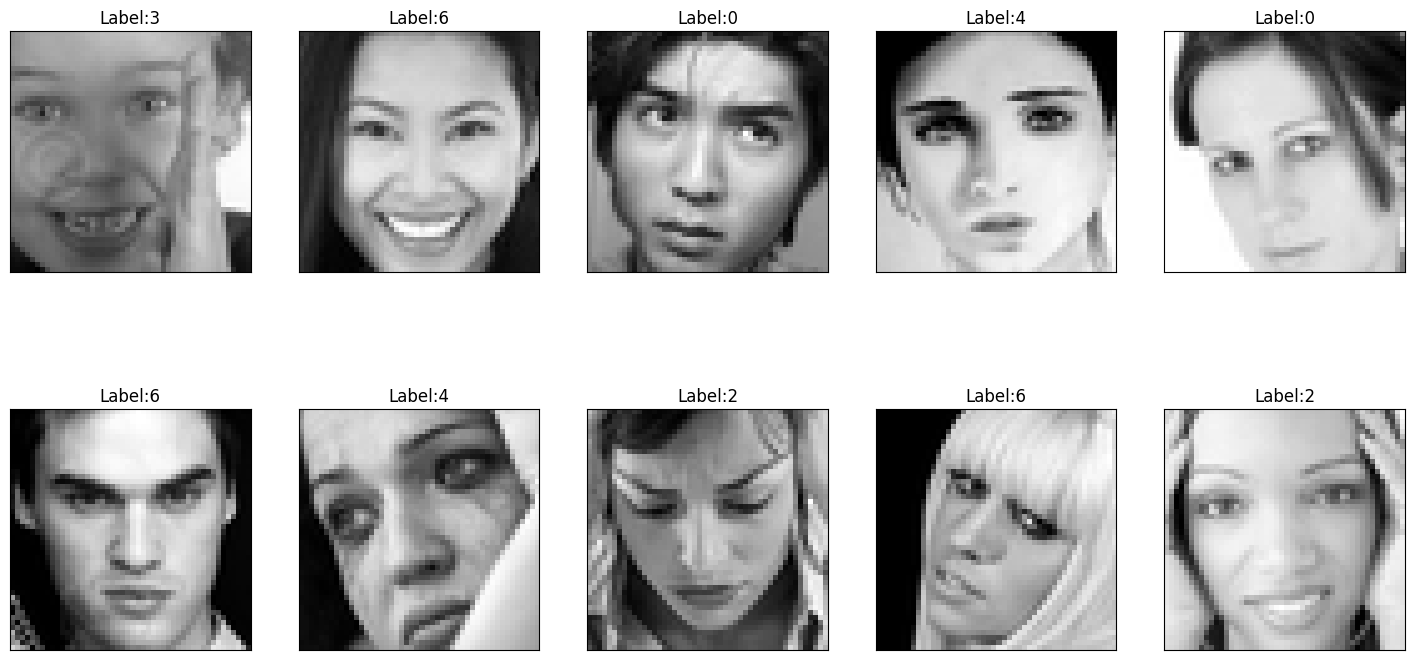

In [ ]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

### **Question 1: Can you visualize the data projected onto two principal components? (2 points)**

***Answer 1: Sử dụng PCA với (n_components = 2) và plot lên biểu đồ trong không gian 2 chiều, với Matplotlib***

In [ ]:
from sklearn.decomposition import PCA

# Dùng PCA
images_reshaped = images.reshape(images.shape[0], -1)
pca = PCA(n_components=2)
pca.fit(images_reshaped)

PCA(n_components=2)

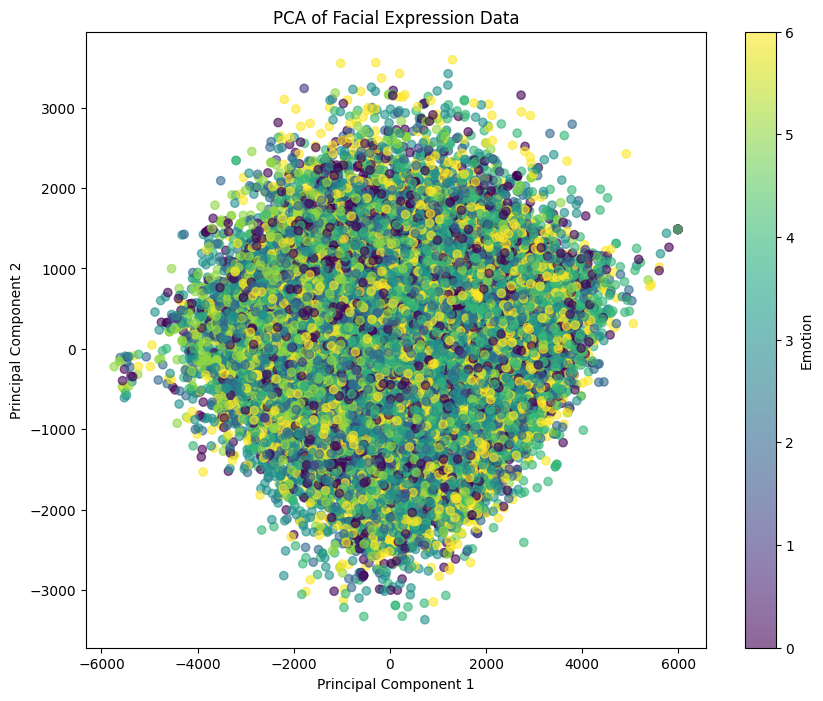

In [ ]:
import matplotlib.pyplot as plt

""" ------------------------------------------------------------------------"""
images_pca = pca.transform(images_reshaped)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=range(7), label='Emotion')
plt.title('PCA of Facial Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### Plot data lên biểu đồ trong không gian 3 chiều

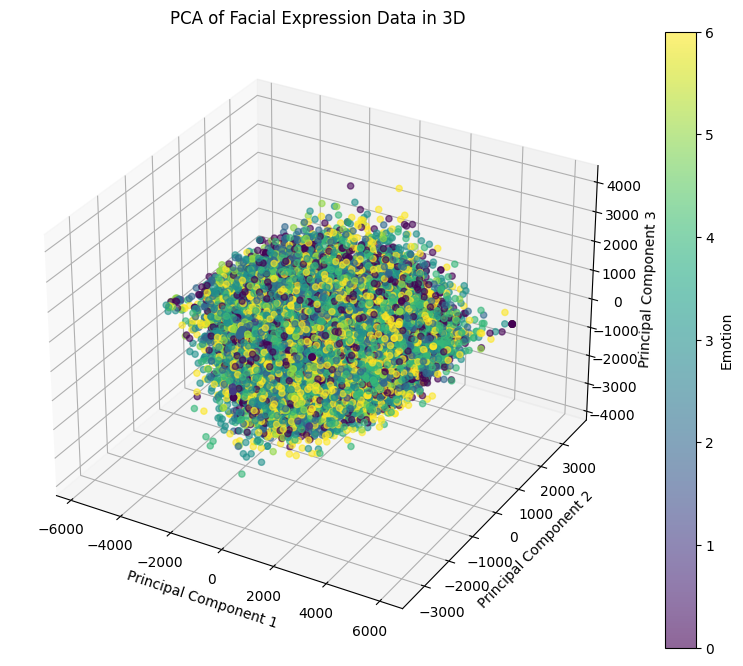

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Dùng PCA để giảm chiều dữ liệu xuống còn 3 thành phần chính
pca = PCA(n_components=3)
images_pca_3d = pca.fit_transform(images_reshaped)

# Tạo một figure và một subplot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ biểu đồ phân tán 3D
scatter = ax.scatter(images_pca_3d[:, 0], images_pca_3d[:, 1], images_pca_3d[:, 2], c=labels, cmap='viridis', alpha=0.6)

# Thêm thanh màu và các nhãn
cbar = plt.colorbar(scatter, ticks=range(7), label='Emotion')
cbar.set_label('Emotion')

# Thêm tiêu đề và nhãn trục
ax.set_title('PCA of Facial Expression Data in 3D')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Hiển thị biểu đồ
plt.show()

In [ ]:
"""
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
# pca.fit(images) ## modify images' array to the appropriate shape
"""

In [ ]:
"""
## transform for visualizing here
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape
# images_pca.shape
"""

### **Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_``` ? Explain your selection process. (2 points)**

***Answer 2:***

--------

*Trong các tấm ảnh, ta thấy rằng khuôn mặt chiếm gần hết các pixel trong tấm ảnh, do đó ta giữ lại một lượng lớn thành phần chính*

*Tuy nhiên, nếu muốn xác định được là cần giữ lại bao nhiêu % lượng thông tin để tối ưu, ta cần thí nghiệm. Ví dụ, ta thí nghiệm với 3 ngưỡng là [87, 90, 93] phần trăm. Tất nhiên với mỗi ngưỡng này, ta tìm được số lượng thành phần chính tương ứng (number_of_combonents)*

*Ta có thể dùng vòng lặp, nhưng vì giai đoạn này không quá quan trọng nên ta tiết kiệm thời gian bằng cách chọn con số 93*

*Trong phần test thử pca dưới đây, ta tìm được số lượng thành phần chính tối ưu để giữ lại 93% lượng thông tin của dữ liệu là `168`, ta sẽ apply nó vào data (data mà đã được chuẩn hóa)*

### Chuẩn hóa dữ liệu với StandardScaler()

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# normalize
scaler = MinMaxScaler()
images_normalized = scaler.fit_transform(images_reshaped)

In [ ]:
images_normalized

array([[0.55686275, 0.58039216, 0.59607843, ..., 0.06666667, 0.0745098 ,
        0.09411765],
       [0.23529412, 0.24705882, 0.21176471, ..., 0.13333333, 0.1254902 ,
        0.12941176],
       [0.52156863, 0.18039216, 0.12156863, ..., 0.49411765, 0.55686275,
        0.57647059],
       ...,
       [0.38039216, 0.36470588, 0.23921569, ..., 0.32156863, 0.41568627,
        0.63529412],
       [0.99607843, 0.89411765, 0.84705882, ..., 0.74509804, 0.85490196,
        0.87843137],
       [0.46666667, 0.39607843, 0.07058824, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
images_normalized.shape

(35887, 2304)

### Dùng PCA giữ lại khoảng 93% phân phối của tấm ảnh, ta tìm được số lượng thành phần chính là 171

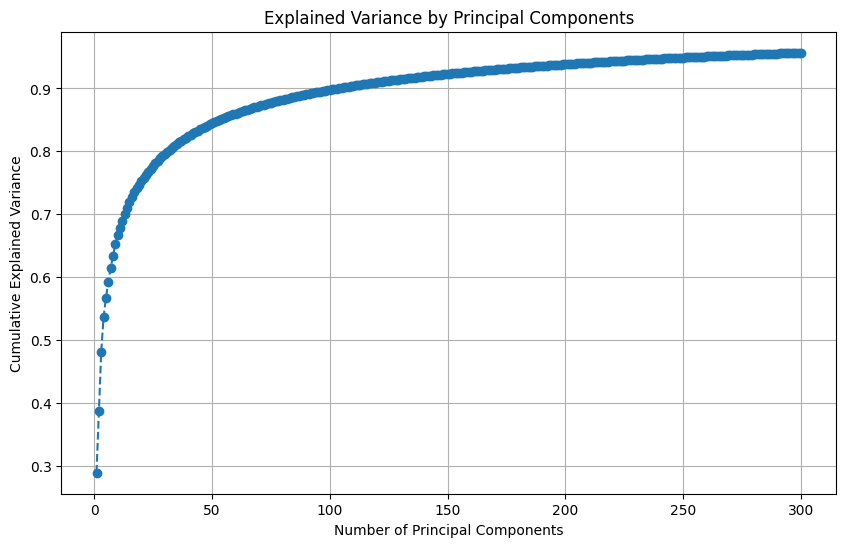

Optimal number of principal components: 171


In [ ]:
pca2 = PCA(n_components = 300)
pca2.fit(images_reshaped)

explained_variance_ratio = pca2.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()

optimal_num_components = np.argmax(cumulative_explained_variance >= 0.93) + 1
print(f'Optimal number of principal components: {optimal_num_components}')

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

### **Question 3:**
Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### **Answer 3:**

### **Xem các bước làm bên dưới**

In [ ]:
from sklearn.decomposition import PCA

pca_171 = PCA(n_components=171)
images_pca = pca_171.fit_transform(images_normalized)

In [ ]:
print(f'Shape of data after PCA: {images_pca.shape}')

Shape of data after PCA: (35887, 171)


### **Tiến hành sử dụng 4 model cho cả 2 data gốc và data sau khi đã dùng PCA**

------

**Các model khả thi:**

1. SVM
2. Random Forest
3. KNN
4. MLP

### Split data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(images_normalized, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_norm.shape[0]}, Testing set size: {X_test_norm.shape[0]}")

Training set size: 28709, Testing set size: 7178


In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(images_pca,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=42)

print(f"Training set size: {X_train_pca.shape[0]}, Testing set size: {X_test_pca.shape[0]}")

Training set size: 28709, Testing set size: 7178


### **Model 3.1: `RandomForestClassifier()` trên dữ liệu nhỏ, chưa qua xử lý pca**

### Được train trên một notebook khác

* Mất 4 tiếng
* Accuracy : 45.4%
* Class đạt hiệu suất tốt nhất : Class `5`


In [ ]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from tqdm import tqdm

# dùng thêm thanh tiến trình để theo dõi quá trình train
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


for i in tqdm(range(100), desc='Training Progress'):
    rf_model.fit(X_train_norm, y_train_norm)

# predict và evaluate
y_pred_rf = rf_model.predict(X_test_norm)
accuracy_rf = accuracy_score(y_test_norm, y_pred_rf)
print(f"Độ chính xác trên dữ liệu đã chuẩn hóa: {accuracy_rf}")
print(classification_report(y_test_norm, y_pred_rf))
print(confusion_matrix(y_test_norm, y_pred_rf))

Training Progress: 100%|██████████| 100/100 [3:52:38<00:00, 139.58s/it]


Độ chính xác trên dữ liệu đã chuẩn hóa: 0.45458344942881024
              precision    recall  f1-score   support

           0       0.46      0.19      0.27      1007
           1       0.97      0.29      0.45       103
           2       0.49      0.29      0.36      1043
           3       0.45      0.77      0.57      1814
           4       0.34      0.35      0.34      1197
           5       0.71      0.60      0.65       812
           6       0.40      0.36      0.38      1202

    accuracy                           0.45      7178
   macro avg       0.54      0.41      0.43      7178
weighted avg       0.47      0.45      0.44      7178

[[ 195    1   69  356  211   33  142]
 [   5   30   14   23   14    6   11]
 [  62    0  299  308  195   75  104]
 [  46    0   56 1402  156   31  123]
 [  58    0   73  426  415   26  199]
 [  21    0   41  139   46  489   76]
 [  41    0   58  448  194   28  433]]


### **Model 3.2: `RandomForestClassifier()` trên dữ liệu nhỏ, đã qua xử lý pca**

### Được train trên một notebook khác

* Mất 1 tiếng 40 phút
* Accuracy : 41.6%
* Class ổn định nhất : Class `5`
------



In [ ]:
from tqdm import tqdm

# dùng thêm thanh tiến trình để theo dõi quá trình train
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)


for i in tqdm(range(100), desc='Training Progress'):
    rf_model_pca.fit(X_train_pca, y_train_pca)

# predict và evaluate
y_pred_rf_pca = rf_model_pca.predict(X_test_pca)
accuracy_rf_pca = accuracy_score(y_test_pca, y_pred_rf_pca)
print(f"Độ chính xác trên dữ liệu đã chuẩn hóa: {accuracy_rf_pca}")
print(classification_report(y_test_pca, y_pred_rf_pca))
print(confusion_matrix(y_test_pca, y_pred_rf_pca))

Training Progress: 100%|██████████| 100/100 [1:40:43<00:00, 60.43s/it]


Độ chính xác trên dữ liệu đã chuẩn hóa: 0.4159933129005294
              precision    recall  f1-score   support

           0       0.45      0.15      0.23      1007
           1       0.97      0.29      0.45       103
           2       0.52      0.24      0.33      1043
           3       0.37      0.82      0.51      1814
           4       0.33      0.27      0.30      1197
           5       0.79      0.51      0.62       812
           6       0.39      0.28      0.32      1202

    accuracy                           0.42      7178
   macro avg       0.55      0.37      0.39      7178
weighted avg       0.46      0.42      0.39      7178

[[ 156    1   40  510  158   19  123]
 [   5   30    5   44    6    3   10]
 [  49    0  250  473  136   46   89]
 [  32    0   51 1483  146   12   90]
 [  50    0   59  590  323   18  157]
 [  27    0   38  221   57  413   56]
 [  29    0   41  640  151   10  331]]


## 4. Evaluating Classification Performance

### **Question 4:**

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



### **Answer 4: (Cập nhật lần 3)**

Quá trình `evaluating` và `reporting` được thực hiện trong phần 3 phía trên.

1. Các "metric score" đều xêm xêm nhau, nên gần như không có class nào mà model predict sai nhiều. Tuy nhiên, với class `1`, ta thấy dữ liệu của class `1` rất ít, có nguy cơ model sẽ không thể predict tốt class này, nhưng một số model vẫn predict tốt (tốt so với các class còn lại) nếu như cho nó đủ số lần lặp và số lượng "lần mà model nhìn qua toàn bộ dữ liệu"

2. Class `5` luôn đạt những điểm số cao, chứng tỏ data (images) ở class 5 biểu diễn rất rõ thuộc tính của class đó.

3. Class `0` và class `4` thay phiên nhau đạt hiệu suất thấp trong tất cả các model trong thí nghiệm trong notebook này.

4. Model `RandomForest` trong notebook này đạt tối đa 45% accuracy

5. Precision cao nhất ở class `5` là 79% (tăng hơn 8% sau khi qua xử lý pca)